In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

import anndata as ad
import spatialdata as sd
import spatialdata_plot
from spatialdata import SpatialData, polygon_query
from spatialdata_io import xenium

import scanpy as sc
import squidpy as sq
import cellcharter as cc
import scvi

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib_venn import venn3
from matplotlib.colors import ListedColormap

from lightning.pytorch import seed_everything

import os
import mygene
import copy

from pathlib import Path

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import scipy.stats as stats
from scipy.stats import gaussian_kde, pearsonr, spearmanr
from scipy.signal import find_peaks
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, adjusted_rand_score

/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid

In [4]:
varrone_df = pd.read_csv('/mnt/ptemp/virginia/project/Xenium_V1_FFPE_Human_Breast_IDC_cell_types.csv')

In [5]:
adata_big = sc.read_h5ad("/mnt/ptemp/virginia/project/breast_cancer_atlas_cellxgene_epithelial.h5ad")

In [6]:
adata_small = sc.read('/mnt/ptemp/virginia/project/adata_new.h5ad')

In [7]:
xenium = sd.read_zarr("/mnt/ptemp/virginia/project/Xenium_V1_FFPE_Human_Breast_IDC.zarr")

/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [8]:
# Carico il file 'epithelial_cells' che contiene solo le cellule epiteliali con la classificazione di Marco
epithelial_cells = sc.read_h5ad("epithelial_cells_cell_type_prediction.h5ad")

In [9]:
# Normalizzo i counts per cella (per correggere per la library size)
sc.pp.normalize_total(epithelial_cells, inplace=True)
sc.pp.log1p(epithelial_cells)                     

/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:235: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/scanpy/tools/_utils.py:40: UserWarning: You’re trying to run this on 280 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


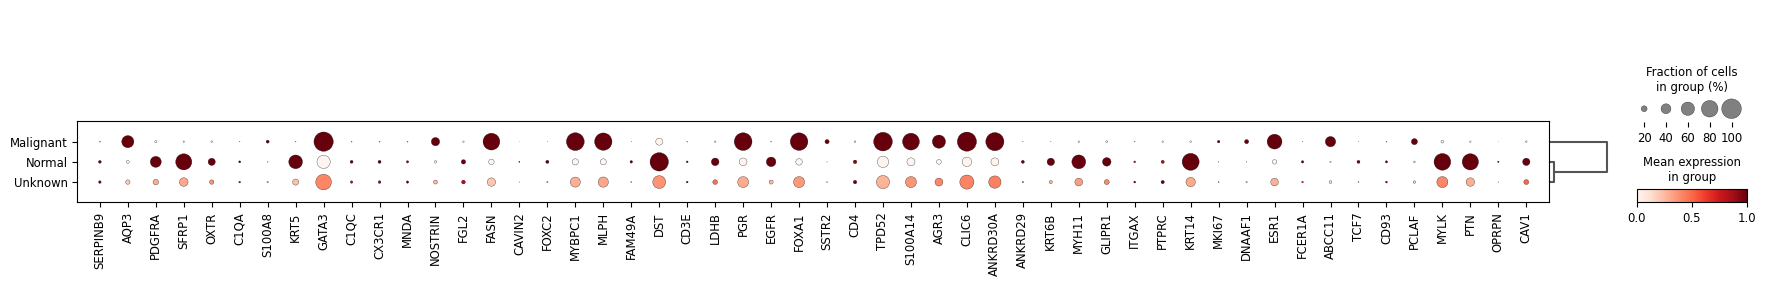

In [10]:
# 1. DGE
sc.tl.rank_genes_groups(
    epithelial_cells,
    groupby='cell_type_prediction',
    method='wilcoxon')

# 2. Estraggo e filtro i geni per ciascun gruppo
top_genes_dict = {}
filtered_gene_cutoff = 0.58  # logFC
pval_cutoff = 0.01
top_n = 20

group_names = epithelial_cells.uns['rank_genes_groups']['names'].dtype.names

for group in group_names:
    df = sc.get.rank_genes_groups_df(epithelial_cells, group=group)

    filtered = df[
        (df['logfoldchanges'] > filtered_gene_cutoff) &
        (df['pvals'] < pval_cutoff)    ]

    gene_ids = filtered.sort_values(by='logfoldchanges', ascending=False)['names'].head(top_n).tolist()
    top_genes_dict[group] = gene_ids

# 3. Estraggo i gruppi anche fuori dal loop
top_genes_malignant = top_genes_dict.get('Malignant', [])
top_genes_normal = top_genes_dict.get('Normal', [])
top_genes_unknown = top_genes_dict.get('Unknown', [])


# 4. Calcolo lo score per ogni gruppo
for group, genes in top_genes_dict.items():
    sc.tl.score_genes(epithelial_cells, gene_list=genes, score_name=f"{group}_signature_score")

# 5. Visualizzazione: Dotplot e Heatmap dei geni filtrati
# Unisco tutti i geni distintivi dei gruppi
all_top_genes = list(set(sum(top_genes_dict.values(), [])))

sc.pl.dotplot(
    epithelial_cells,
    var_names=all_top_genes,
    groupby='cell_type_prediction',
    standard_scale='var',
    dendrogram=True,
    save='dotplot_top_genes.pdf')

/tmp/ipykernel_1292423/900442862.py:20: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df_melted, x='Signature', y='Score', hue='cell_type_prediction',


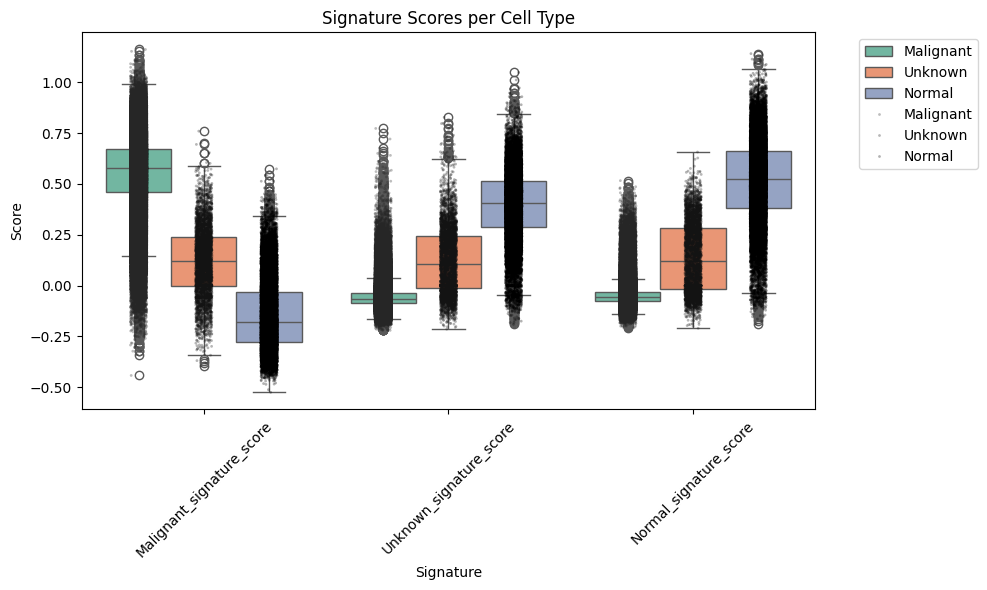

In [33]:
# Costruisco un DataFrame "melted" per seaborn
df = epithelial_cells.obs[['cell_type_prediction', 
                 'Malignant_signature_score', 
                 'Unknown_signature_score', 
                 'Normal_signature_score']].copy()

# Ordino le categorie come desiderato
desired_order = ['Malignant', 'Unknown', 'Normal']
df['cell_type_prediction'] = pd.Categorical(df['cell_type_prediction'], categories=desired_order, ordered=True)

# Converto in long format per seaborn
df_melted = df.melt(id_vars='cell_type_prediction', 
                    var_name='Signature', 
                    value_name='Score')

# Boxplot con overlay di punti
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_melted, x='Signature', y='Score', hue='cell_type_prediction', 
            palette='Set2', hue_order=desired_order)
sns.stripplot(data=df_melted, x='Signature', y='Score', hue='cell_type_prediction', 
              dodge=True, color='black', alpha=0.3, size=2, hue_order=desired_order)

plt.title('Signature Scores per Cell Type')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [34]:
# Verifico quanto sono significativi gli score (ovvero controllo lo score medio per ogni gruppo, per ciascuna signature)
df.groupby('cell_type_prediction')[
    ['Malignant_signature_score', 'Unknown_signature_score', 'Normal_signature_score']
].mean()

# lo score Unknown_signature_score è più altro nelle Normal, quindi non è discriminativo

/tmp/ipykernel_1292423/1130415330.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('cell_type_prediction')[


Malignant_signature_score  Unknown_signature_score  \
cell_type_prediction                                                       
Malignant                              0.556739                -0.057730   
Unknown                                0.122258                 0.121792   
Normal                                -0.143178                 0.395440   

                      Normal_signature_score  
cell_type_prediction                          
Malignant                          -0.047440  
Unknown                             0.137157  
Normal                              0.515623

Normal_signature_score Estimated threshold: 0.125
Malignant_signature_score Estimated threshold: 0.062


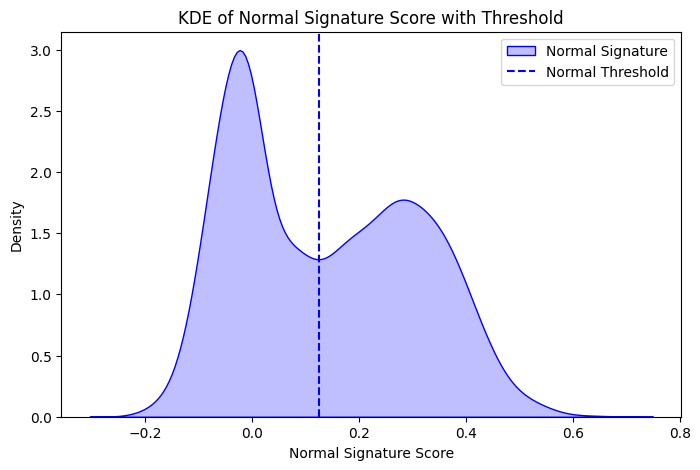

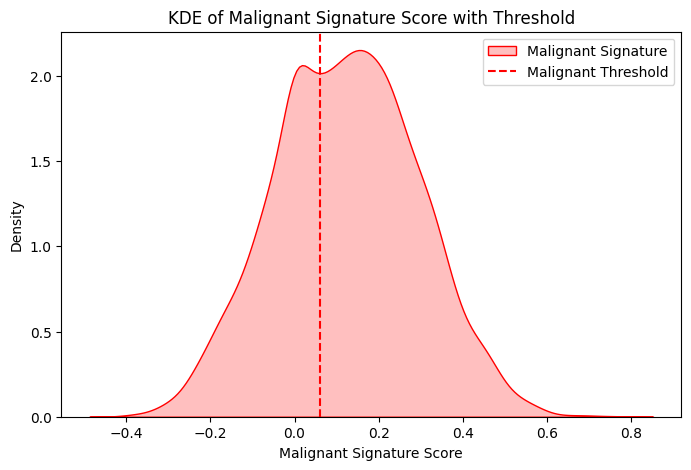

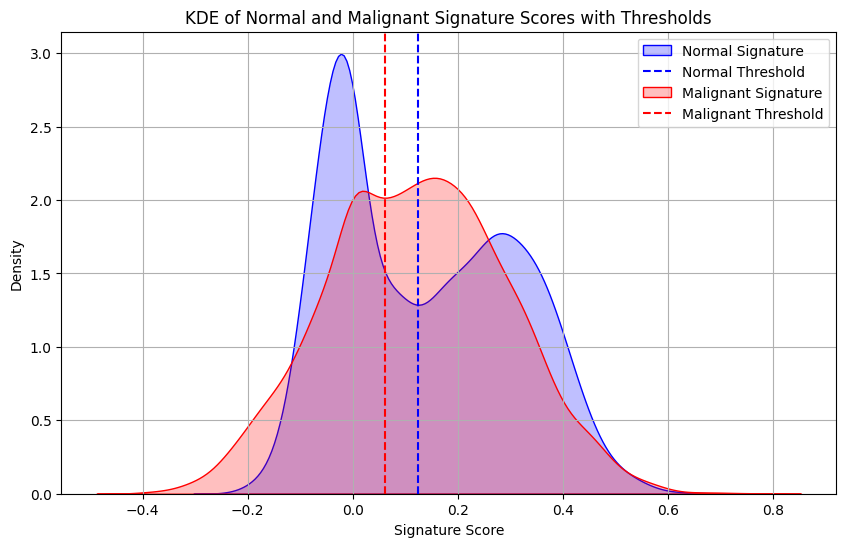


Correlation between the two signatures (epithelial Unknown cells):
                           Normal_signature_score  Malignant_signature_score
Normal_signature_score                   1.000000                   0.284004
Malignant_signature_score                0.284004                   1.000000


In [35]:
# 1. Seleziono solo le cellule Unknown
df_unknown = df[df['cell_type_prediction'] == 'Unknown'].copy()

# 2. Funzione migliorata per trovare soglia e classificare
def analyze_signature(df, column, direction='greater'):
    scores = df[column].dropna().values
    
    if len(scores) < 10:
        print(f"[{column}] Troppi pochi valori per stimare la soglia.")
        return df, None, None

    # Calcola KDE usando gaussian_kde
    kde = gaussian_kde(scores)
    x_vals = np.linspace(min(scores), max(scores), 1000)
    y_vals = kde(x_vals)

    # Trova i picchi
    peaks, _ = find_peaks(y_vals)
    if len(peaks) < 2:
        print(f"[{column}] Less than two peaks detected: unable to estimate the threshold.")
        return df, None, None

    # Trova la valle tra i due picchi principali
    peak1, peak2 = sorted(peaks[:2])
    valley_idx = np.argmin(y_vals[peak1:peak2])
    threshold = x_vals[peak1 + valley_idx]

    print(f"{column} Estimated threshold: {threshold:.3f}")

    # Crea nuova colonna di classificazione
    class_column = f"new_class_{column.split('_')[0].lower()}"
    if direction == 'greater':
        df[class_column] = df[column].apply(lambda x: 'Malignant' if x > threshold else 'Normal')
    else:
        df[class_column] = df[column].apply(lambda x: 'Malignant' if x < threshold else 'Normal')

    return df, threshold, class_column

# 3. Applica la funzione alle due signature
df_unknown, threshold_normal, class_col_normal = analyze_signature(df_unknown, 'Normal_signature_score', direction='less')
df_unknown, threshold_malignant, class_col_malignant = analyze_signature(df_unknown, 'Malignant_signature_score', direction='greater')

# 4. Plot separato per Normal
plt.figure(figsize=(8, 5))
sns.kdeplot(df_unknown['Normal_signature_score'].dropna(), fill=True, color='blue', label='Normal Signature')
if threshold_normal:
    plt.axvline(threshold_normal, color='blue', linestyle='--', label='Normal Threshold')
plt.title('KDE of Normal Signature Score with Threshold')
plt.xlabel('Normal Signature Score')
plt.ylabel('Density')
plt.legend()
plt.show()

# 5. Plot separato per Malignant
plt.figure(figsize=(8, 5))
sns.kdeplot(df_unknown['Malignant_signature_score'].dropna(), fill=True, color='red', label='Malignant Signature')
if threshold_malignant:
    plt.axvline(threshold_malignant, color='red', linestyle='--', label='Malignant Threshold')
plt.title('KDE of Malignant Signature Score with Threshold')
plt.xlabel('Malignant Signature Score')
plt.ylabel('Density')
plt.legend()
plt.show()

# 6. Plot combinato
plt.figure(figsize=(10, 6))
sns.kdeplot(df_unknown['Normal_signature_score'].dropna(), fill=True, color='blue', label='Normal Signature')
if threshold_normal:
    plt.axvline(threshold_normal, color='blue', linestyle='--', label='Normal Threshold')
sns.kdeplot(df_unknown['Malignant_signature_score'].dropna(), fill=True, color='red', label='Malignant Signature')
if threshold_malignant:
    plt.axvline(threshold_malignant, color='red', linestyle='--', label='Malignant Threshold')
plt.title('KDE of Normal and Malignant Signature Scores with Thresholds')
plt.xlabel('Signature Score')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.show()

# 7. Correlazione tra le due firme
correlation = df_unknown[['Normal_signature_score', 'Malignant_signature_score']].corr()
print("\nCorrelation between the two signatures (epithelial Unknown cells):")
print(correlation)


In [36]:
pd.crosstab(df_unknown['new_class_normal'], df_unknown['new_class_malignant'])

new_class_malignant  Malignant  Normal
new_class_normal                      
Malignant                 1224    1257
Normal                    1828     573

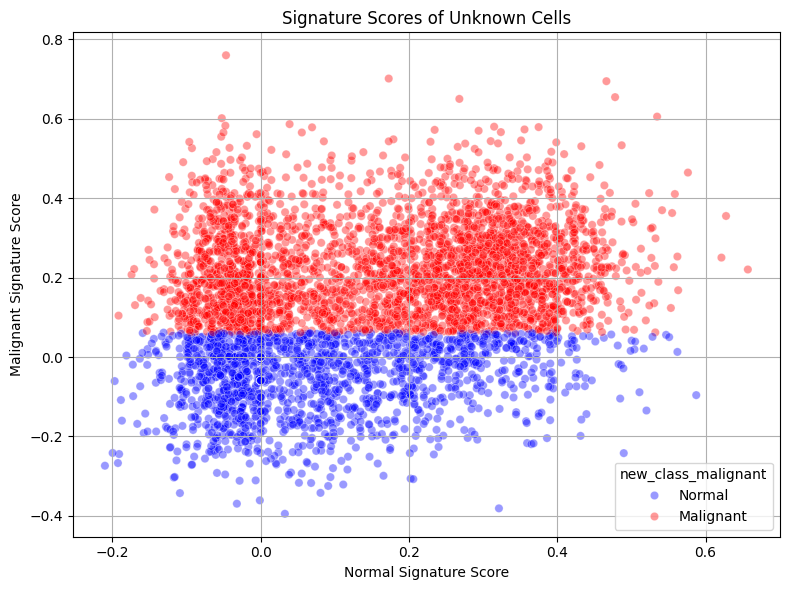

In [82]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_unknown,
    x='Normal_signature_score',
    y='Malignant_signature_score',
    hue='new_class_malignant',  # oppure usa 'new_class_normal'
    alpha=0.4,
    palette={'Normal': 'blue', 'Malignant': 'red'}
)
plt.title('Signature Scores of Unknown Cells')
plt.xlabel('Normal Signature Score')
plt.ylabel('Malignant Signature Score')
plt.grid(True)
plt.tight_layout()
plt.savefig('figures/scatter_new_class_malignant.pdf', format='pdf')
plt.show()

In [38]:
match = (df_unknown['new_class_normal'] == df_unknown['new_class_malignant']).sum()
total = len(df_unknown)
print(f"Agreement between the two classifications: {match}/{total} ({100 * match/total:.2f}%)")

Agreement between the two classifications: 1797/4882 (36.81%)


In [39]:
# DGE: Unknown vs Malignant
sc.tl.rank_genes_groups(
    epithelial_cells,
    groupby='cell_type_prediction',
    groups=['Unknown'],
    reference='Malignant',
    method='wilcoxon')

# Salvo i risultati in un DataFrame
dge_um = sc.get.rank_genes_groups_df(epithelial_cells, group='Unknown')

In [40]:
# DGE: Unknown vs Normal
sc.tl.rank_genes_groups(
    epithelial_cells,
    groupby='cell_type_prediction',
    groups=['Unknown'],
    reference='Normal',
    method='wilcoxon')

# Salvo i risultati in un DataFrame
dge_un = sc.get.rank_genes_groups_df(epithelial_cells, group='Unknown')

In [41]:
# Estrai i geni significativi con p-value < 0.01 e logFC > 0.58
sig_um = dge_um[(dge_um['pvals_adj'] < 0.01) & (dge_um['logfoldchanges'] > 0.58)]
sig_un = dge_un[(dge_un['pvals_adj'] < 0.01) & (dge_un['logfoldchanges'] > 0.58)]

# Geni in comune tra le due condizioni
common_genes = set(sig_um['names']).intersection(set(sig_un['names']))
print(f"Significant genes shared between Unknown vs Malignant and Unknown vs Normal: {len(common_genes)}")

Significant genes shared between Unknown vs Malignant and Unknown vs Normal: 4


In [42]:
common_df = pd.merge(
    sig_um[['names', 'logfoldchanges']].rename(columns={'logfoldchanges': 'logFC_UM'}),
    sig_un[['names', 'logfoldchanges']].rename(columns={'logfoldchanges': 'logFC_UN'}),
    on='names')
display(common_df.sort_values(by='logFC_UM', key=abs, ascending=False))

names  logFC_UM  logFC_UN
0    TCIM  1.464527  1.415332
1  CCDC80  1.445075  0.896418
2  CXCL12  0.808875  0.714261
3     LUM  0.731318  0.836458

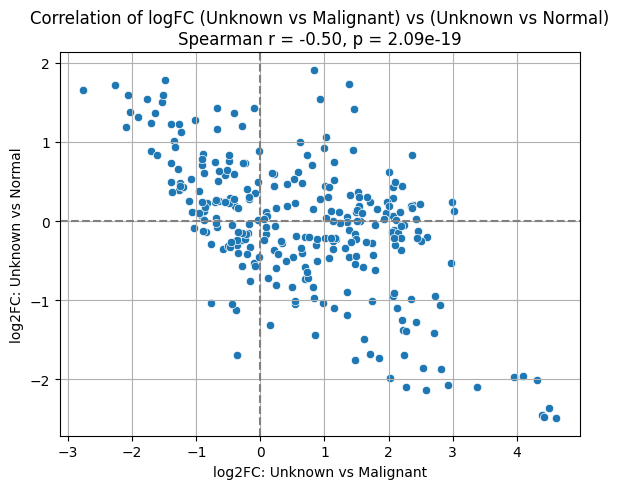

In [43]:
# Valuto la correlaione tra gli score
# Unisci i due DataFrame sulla colonna 'names'
merged = pd.merge(
    dge_um[['names', 'logfoldchanges']].rename(columns={'logfoldchanges': 'logFC_UM'}),
    dge_un[['names', 'logfoldchanges']].rename(columns={'logfoldchanges': 'logFC_UN'}),
    on='names')

# Calcola la correlazione
corr, pval = spearmanr(merged['logFC_UM'], merged['logFC_UN'])

# Visualizza
plt.figure(figsize=(6, 5))
sns.scatterplot(data=merged, x='logFC_UM', y='logFC_UN')
plt.title(f'Correlation of logFC (Unknown vs Malignant) vs (Unknown vs Normal)\nSpearman r = {corr:.2f}, p = {pval:.2e}')
plt.xlabel('log2FC: Unknown vs Malignant')
plt.ylabel('log2FC: Unknown vs Normal')
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.grid(True)
plt.tight_layout()
plt.savefig('figures/logfc_correlation.pdf', format='pdf')

plt.show()

In [44]:
pure_unknown = common_df[
    (common_df['logFC_UM'] > 0) & 
    (common_df['logFC_UN'] > 0)
]
print(f"Candidate marker genes of the Unknown cells (overexpressed in both comparisons): {len(pure_unknown)}")
display(pure_unknown.sort_values(by='logFC_UM', ascending=False))

Candidate marker genes of the Unknown cells (overexpressed in both comparisons): 4


names  logFC_UM  logFC_UN
0    TCIM  1.464527  1.415332
1  CCDC80  1.445075  0.896418
2  CXCL12  0.808875  0.714261
3     LUM  0.731318  0.836458

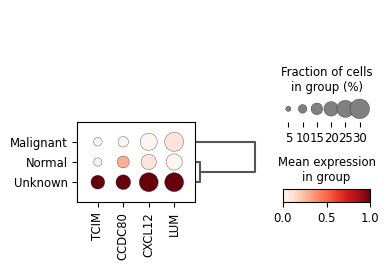

In [45]:
sc.pl.dotplot(
    epithelial_cells,
    var_names=pure_unknown['names'].tolist(),
    groupby='cell_type_prediction',
    standard_scale='var',
    dendrogram=True,
    save='unknown_markers.pdf')

In [48]:
adata = xenium.table

# Unisci i dati sul campo 'cell_id'
adata.obs = adata.obs.merge(varrone_df[['cell_id', 'level1', 'level2']],
                            on='cell_id',
                            how='left')

/tmp/ipykernel_1292423/120584968.py:1: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  adata = xenium.table


In [49]:
# Analizzo in quali cell type (colonna level_1) sono maggiormente espressi i geni LUM, CXCL12, CCDC80 e TCIM nell'oggetto SpatialData (Xenium)

# 1. Controllo che i geni siano presenti
print(adata.var_names)

# Verifica che i geni di interesse siano presenti
genes = ['LUM', 'CXCL12', 'CCDC80', 'TCIM']
for gene in genes:
    print(f"{gene} present: {gene in adata.var_names}")

# 2. Calcolo l'espressione media per cell_type(level_1)

# Estrai i dati di espressione dei geni selezionati
adata_selected = adata[:, genes]

# Crea un DataFrame con le espressioni e il tipo cellulare
df = pd.DataFrame(adata_selected.X.toarray(), columns=genes, index=adata.obs.index)
df['cell_type'] = adata.obs['level2'].values

# Calcola l'espressione media per ogni gene in ciascun cell type
mean_expression = df.groupby('cell_type')[genes].mean()

# Ordina decrescente per ogni gene (facoltativo)
for gene in genes:
    print(f"\n {gene} - cell types with highest average expression:")
    display(mean_expression[[gene]].sort_values(by=gene, ascending=False).head())

Index(['ABCC11', 'ACTA2', 'ACTG2', 'ADAM9', 'ADGRE5', 'ADH1B', 'ADIPOQ',
       'AGR3', 'AIF1', 'AKR1C1',
       ...
       'TUBA4A', 'TUBB2B', 'UCP1', 'USP53', 'VOPP1', 'VWF', 'WARS', 'ZEB1',
       'ZEB2', 'ZNF562'],
      dtype='object', length=280)
LUM present: True
CXCL12 present: True
CCDC80 present: True
TCIM present: True

 LUM - cell types with highest average expression:


LUM
cell_type             
Fibroblast   15.384718
Mast_cell     5.991735
Adipocyte     5.704152
Myeloid       5.517873
Plasma_cell   5.359124


 CXCL12 - cell types with highest average expression:


CXCL12
cell_type            
Fibroblast   5.657942
Adipocyte    3.359285
Plasma_cell  2.882847
Myeloid      2.595531
Endothelial  2.420941


 CCDC80 - cell types with highest average expression:


CCDC80
cell_type            
Fibroblast   5.027412
Adipocyte    3.261822
Mast_cell    2.330185
Plasma_cell  2.221533
Myeloid      1.723956


 TCIM - cell types with highest average expression:


TCIM
cell_type                     
Endothelial           1.953152
Pericyte              0.622940
Fibroblast            0.308636
Malignant_epithelial  0.242209
Normal_epithelial     0.235348

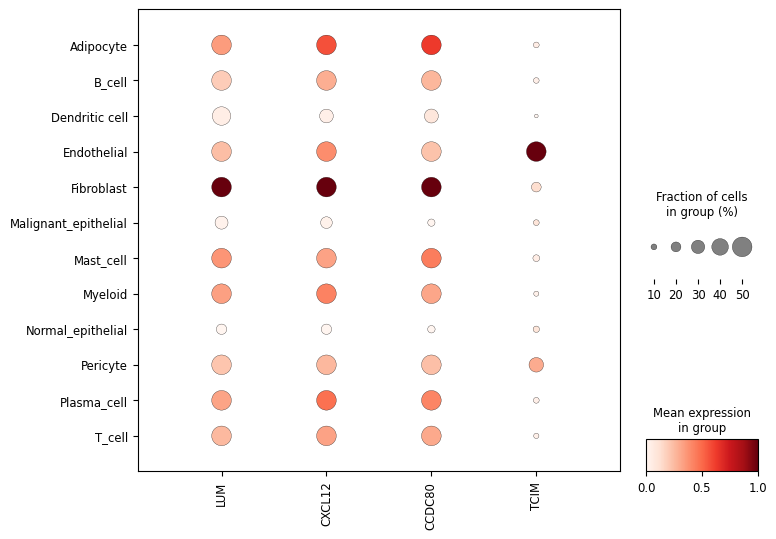

In [50]:
# Visualizzo con un dotplot che visualizzi contemporaneamente:
# l’espressione media per cell type (level1)
# la percentuale di cellule che esprimono ciascun gene (dot size)

# Geni di interesse
genes = ['LUM', 'CXCL12', 'CCDC80', 'TCIM']

# Dotplot: mostra media e percentuale di espressione per gene e cell type
sc.pl.dotplot(
    adata,
    var_names=genes,
    groupby='level2',
    standard_scale='var',  # opzionale: normalizza valori tra gruppi
    dot_max=0.5,           
    figsize=(8, 6),
    dendrogram=False,      
    show=True)

In [51]:
df_expr = epithelial_cells.to_df().copy()
df_expr['cell_type_prediction'] = epithelial_cells.obs['cell_type_prediction'].values

# Funzione per calcolare % di espressione > 0
def percent_expressed(df, group_col):
    groups = df[group_col].unique()
    result = {}
    for group in groups:
        group_df = df[df[group_col] == group].drop(columns=[group_col])
        percent = (group_df > 0).sum() / group_df.shape[0] * 100
        result[group] = percent
    return pd.DataFrame(result)


percent_expr = percent_expressed(df_expr, 'cell_type_prediction')

genes_specific_to_unknown = percent_expr[
    (percent_expr['Unknown'] > 20) &     # abbassa soglia espressione in Unknown
    (percent_expr['Malignant'] < 20) &  # abbassa soglia in Malignant
    (percent_expr['Normal'] < 20)]

print(genes_specific_to_unknown.sort_values('Unknown', ascending=False).head(20))

# CCDC80 è un gene che codifica una proteina extracellulare contenente un dominio coiled-coil, coinvolta nella regolazione della crescita 
# cellulare, adesione e differenziazione. Questa proteina è considerata un potenziale oncosoppressore, con espressione spesso ridotta in vari 
# tumori, dove la sua perdita favorisce proliferazione e invasività cellulare.
# Il gene CCDC80 è espresso in circa il 20% delle cellule "Unknown" (cioè circa 1 cellula su 5 di questo gruppo ha espressione > 0).

        Malignant    Unknown     Normal
CCDC80  13.055271  20.278574  15.335978


In [37]:
# Possibili interpretazioni biologiche:
# 1. Regolazione differenziale: CCDC80 potrebbe avere un ruolo specifico nelle cellule "Unknown", magari collegato a particolari processi 
# cellulari o stadi di differenziazione non ancora definiti.
# 2. Marcatori di stato cellulare: Essendo espressa diversamente, potrebbe aiutare a distinguere o caratterizzare meglio le cellule "Unknown" 
# rispetto a Malignant o Normal, utile per studi di classificazione o identificazione cellulare.
# 3. Ruolo funzionale: Se CCDC80 è un oncosoppressore come indicato, la sua espressione variabile potrebbe influenzare crescita, adesione o 
#invasività cellulare, implicando potenziali differenze biologiche rilevanti.
# 4. Biomarker potenziale: Differenze marcate possono rendere questo gene un candidato per biomarcatori diagnostici o prognostici, 
# specialmente se l’"Unknown" rappresenta uno stato patologico o di transizione.

/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:235: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


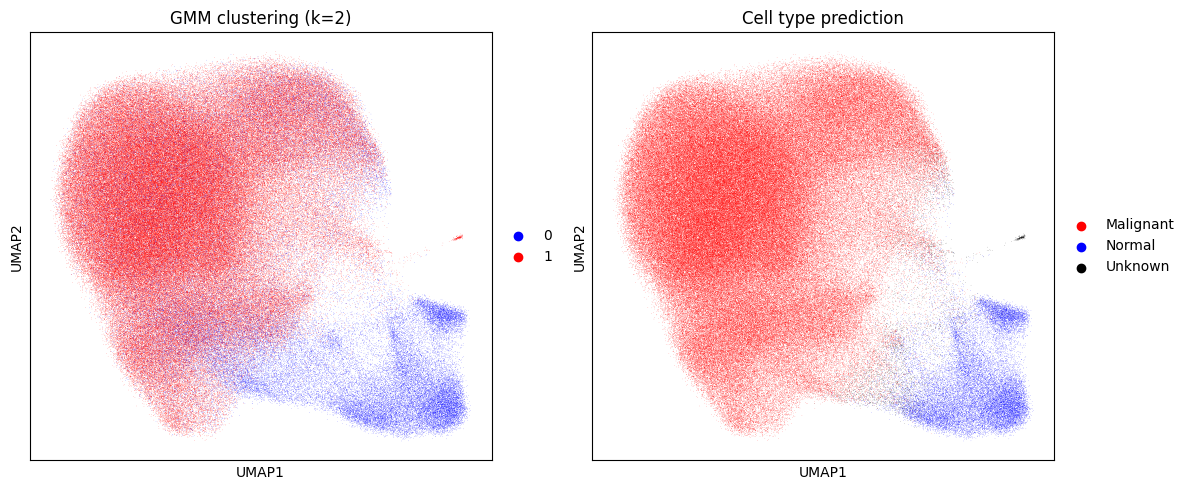

cell_type_prediction  Malignant  Normal  Unknown
GMM_cluster                                     
0                         42273   25160     3299
1                        278111     303     1583


/tmp/ipykernel_1292423/2605672771.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_plot, x='cluster_label',


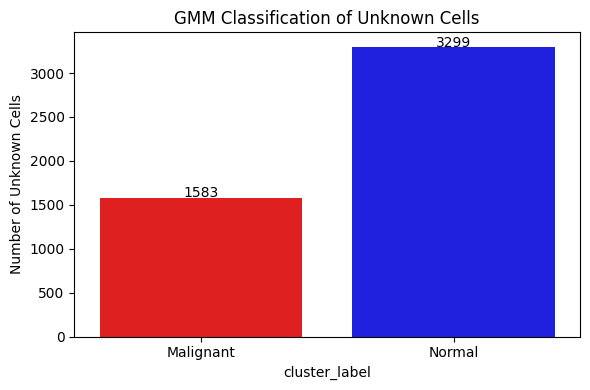

In [56]:
# 1. Unione e filtraggio delle signature
top_all = list(set(top_genes_normal + top_genes_malignant))
genes_present = [gene for gene in top_all if gene in epithelial_cells.var_names]

# 2. Estrai matrice di espressione solo per i geni delle signature (su tutte le cellule)
epithelial_cells_sig = epithelial_cells[:, genes_present].copy()

# 3. Preprocessing: normalizzazione e log1p solo delle feature selezionate
sc.pp.normalize_total(epithelial_cells_sig)
sc.pp.log1p(epithelial_cells_sig)

# 4. GMM su tutto il dataset ma solo usando le signature
X = epithelial_cells_sig.X.toarray() if not isinstance(epithelial_cells_sig.X, np.ndarray) else epithelial_cells_sig.X
gmm = GaussianMixture(n_components=2, random_state=42)
labels = gmm.fit_predict(X)

# 5. Assegna le etichette di cluster al dataset ORIGINALE
epithelial_cells.obs['GMM_cluster'] = labels.astype(str)

# 6. Calcolo UMAP sull'intero dataset originale (perché vuoi visualizzare tutto)
sc.pp.neighbors(epithelial_cells)
sc.tl.umap(epithelial_cells)

# 7. UMAP plot: GMM vs Cell Type
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sc.pl.umap(
    epithelial_cells,
    color='GMM_cluster',
    palette=['blue', 'red'],
    title='GMM clustering (k=2)',
    ax=axes[0],
    show=False)

sc.pl.umap(
    epithelial_cells,
    color='cell_type_prediction',
    palette={'Normal': 'blue', 'Malignant': 'red', 'Unknown': 'black'},
    title='Cell type prediction',
    ax=axes[1],
    show=False)

plt.tight_layout()
fig.savefig('figures/umap_gmm_vs_celltype_allcells.png', dpi=300)
plt.show()

# 8. Tabella incrociata: GMM vs cell type
print(pd.crosstab(epithelial_cells.obs['GMM_cluster'], epithelial_cells.obs['cell_type_prediction']))

# 9. Barplot: classificazione delle cellule Unknown da parte di GMM
unknown_cells = epithelial_cells[epithelial_cells.obs['cell_type_prediction'] == 'Unknown']

# Mappa per interpretare i cluster (opzionale – modifica se necessario)
cluster_label_map = { '0': 'Normal', '1': 'Malignant' }

# Conta i cluster assegnati alle Unknown
df_plot = unknown_cells.obs[['GMM_cluster']].copy()
df_plot['cluster_label'] = df_plot['GMM_cluster'].map(cluster_label_map)

# Ordine e colori desiderati
desired_order = ['Malignant', 'Normal']
desired_palette = {'Malignant': 'red', 'Normal': 'blue'}

# Barplot
plt.figure(figsize=(6,4))
ax = sns.countplot(data=df_plot, x='cluster_label',
                   order=desired_order, palette=desired_palette)

plt.title('GMM Classification of Unknown Cells')
plt.ylabel('Number of Unknown Cells')

# Aggiungi etichette sopra le barre
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 1,
            int(height), ha="center", fontsize=10)

plt.tight_layout()
plt.savefig('figures/barplot_unknown_gmm_classification.png', dpi=300)
plt.show()

▶️ Cluster 0 - n_cells: 70732


/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/scanpy/plotting/_utils.py:491: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


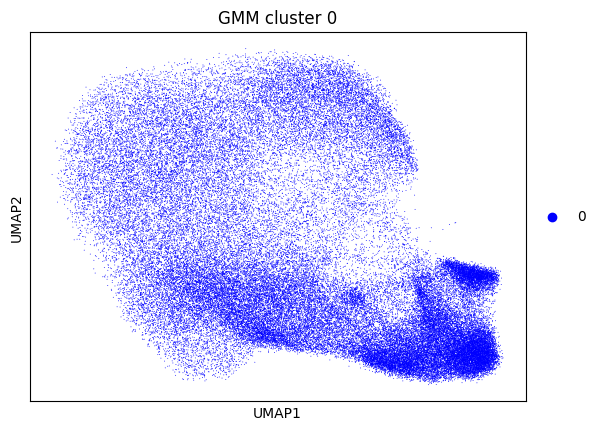

▶️ Cluster 1 - n_cells: 279997


/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/scanpy/plotting/_utils.py:491: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


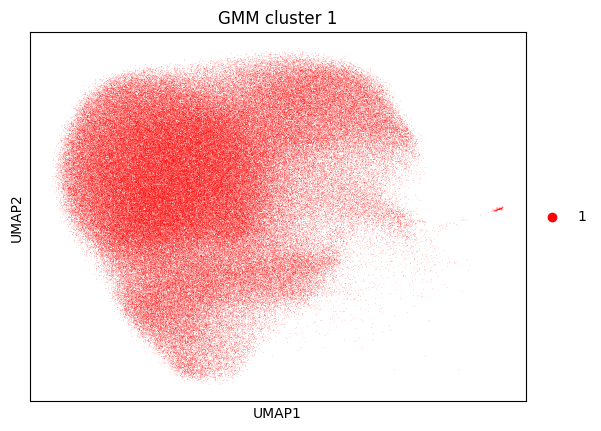

▶️ Cell type: Malignant - n_cells: 320384


/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/scanpy/plotting/_utils.py:491: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


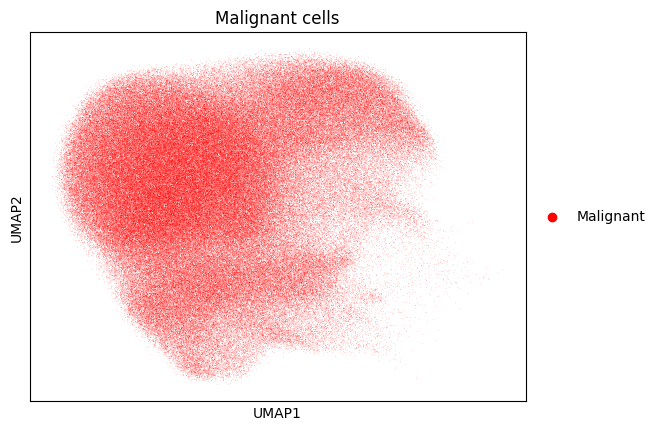

▶️ Cell type: Normal - n_cells: 25463


/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/scanpy/plotting/_utils.py:491: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


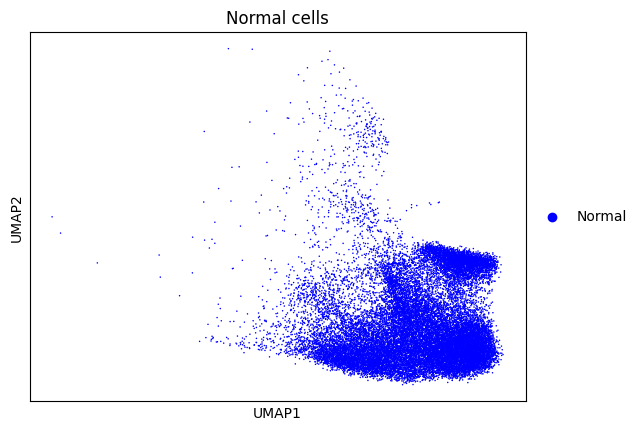

▶️ Cell type: Unknown - n_cells: 4882


/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/scanpy/plotting/_utils.py:491: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


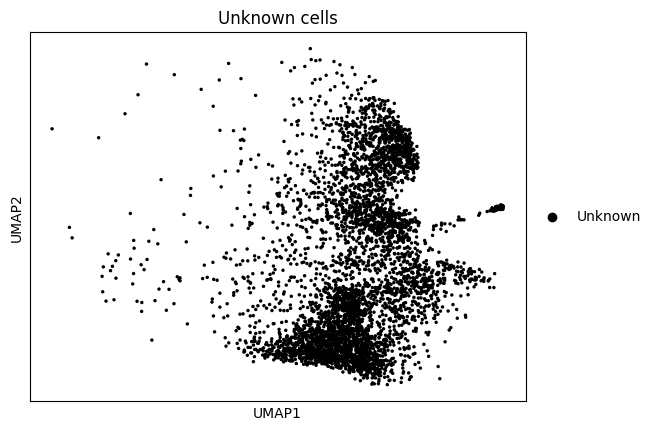

In [68]:
# PLOT SEPARATI PER OGNI CLUSTER di GMM 

for i, color in zip(['0', '1'], ['blue', 'red']):
    subset = epithelial_cells[epithelial_cells.obs['GMM_cluster'].astype(str) == i]
    print(f"▶️ Cluster {i} - n_cells: {subset.n_obs}")
    if subset.n_obs > 0:
        sc.pl.umap(subset, color='GMM_cluster', title=f'GMM cluster {i}',
                   palette=[color], show=True)

# PLOT SEPARATI PER OGNI CLUSTER di cell_type_prediction

for ct, color in zip(['Malignant', 'Normal', 'Unknown'], ['red', 'blue', 'black']):
    subset = epithelial_cells[epithelial_cells.obs['cell_type_prediction'].astype(str) == ct]
    print(f"▶️ Cell type: {ct} - n_cells: {subset.n_obs}")
    if subset.n_obs > 0:
        sc.pl.umap(subset,
                   color='cell_type_prediction',
                   title=f'{ct} cells',
                   palette=[color],
                   show=True)

In [66]:
# FUNZIONE per plottare due UMAP affiancati: a sinistra GMM clustering con Unknown evidenziate, a destra solo Unknown in rosso.

def plot_gmm_vs_unknown_highlight(
    adata,
    feature_key: str,
    cluster_key: str = 'GMM_cluster',
    title_left: str = 'GMM clustering of Unknown cells (highlighted)',
    title_right: str = 'Cell Type Prediction (highlight Unknown)',
    save_path: str = None):
   
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Maschere
    mask_known = adata.obs['cell_type_prediction'].isin(['Normal', 'Malignant'])
    mask_unknown = adata.obs['cell_type_prediction'] == 'Unknown'

    # --- SINISTRA ---
    sc.pl.umap(
        adata[mask_known],
        color='cell_type_prediction',
        palette={'Normal': 'lightgray', 'Malignant': 'lightgray'},
        size=10,
        alpha=0.3,
        ax=axes[0],
        show=False,
        legend_loc=None)
    sc.pl.umap(
        adata[mask_unknown],
        color=cluster_key,
        palette=['blue', 'red'],
        size=10,
        alpha=0.5,
        ax=axes[0],
        show=False,
        legend_loc='right')
    axes[0].set_title(title_left)
    axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), title='GMM cluster')

    # --- DESTRA ---
    sc.pl.umap(
        adata,
        color='cell_type_prediction',
        palette={'Normal': 'lightgray', 'Malignant': 'lightgray', 'Unknown': 'lightgray'},
        size=10,
        alpha=0.5,
        ax=axes[1],
        show=False,
        legend_loc=None)
    sc.pl.umap(
        adata[mask_unknown],
        color='cell_type_prediction',
        palette={'Unknown': 'red'},
        size=10,
        alpha=0.5,
        ax=axes[1],
        show=False)
    axes[1].set_title(title_right)

    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=300)
    plt.show()

/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/scanpy/plotting/_utils.py:491: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list
/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/scanpy/plotting/_utils.py:491: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list
/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/scanpy/plotting/_utils.py:491: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


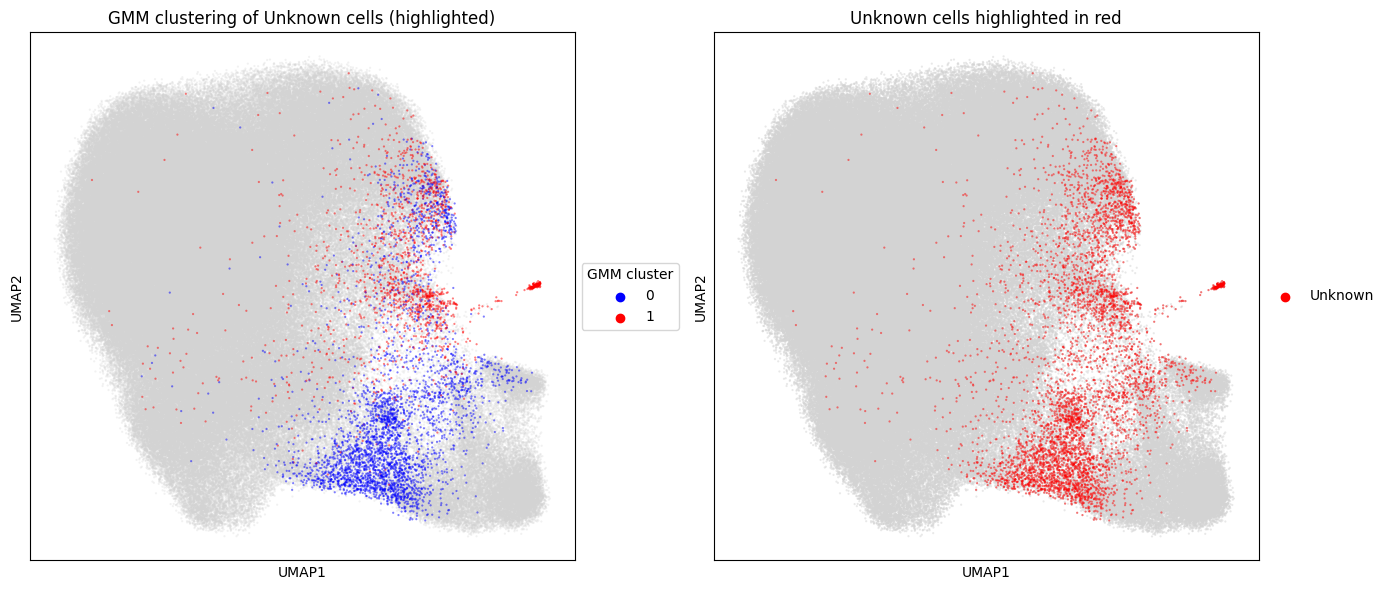

In [67]:
plot_gmm_vs_unknown_highlight(
    adata=epithelial_cells,
    feature_key='cell_type_prediction',
    cluster_key='GMM_cluster',
    title_left='GMM clustering of Unknown cells (highlighted)',
    title_right='Unknown cells highlighted in red',
    save_path='figures/umap_gmm_unknown_highlighted.png'  # salva anche la figura)

/tmp/ipykernel_1292423/860400454.py:15: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_down = normal_sample.concatenate(malignant_sample, unknown_cells)
/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:235: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


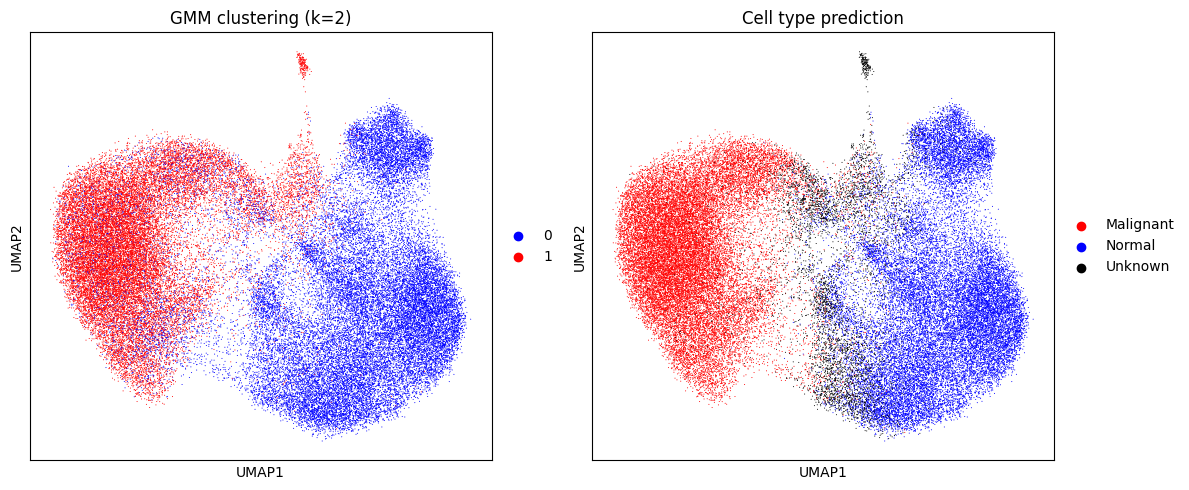

/tmp/ipykernel_1292423/860400454.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


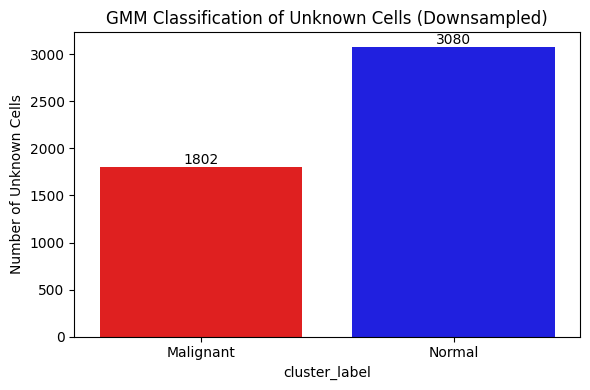

cell_type_prediction  Malignant  Normal  Unknown
GMM_cluster                                     
0                          3327   24595     3080
1                         21673     405     1802


In [64]:
# 1. Filtra cellule Normal, Malignant, Unknown
mask_nmu = epithelial_cells.obs['cell_type_prediction'].isin(['Normal', 'Malignant', 'Unknown'])
adata_nmu = epithelial_cells[mask_nmu].copy()

# 2. Estrai gruppi separatamente
normal_cells = adata_nmu[adata_nmu.obs['cell_type_prediction'] == 'Normal']
malignant_cells = adata_nmu[adata_nmu.obs['cell_type_prediction'] == 'Malignant']
unknown_cells = adata_nmu[adata_nmu.obs['cell_type_prediction'] == 'Unknown']

# 3. Downsampling: 25k Normal + 25k Malignant
normal_sample = normal_cells[np.random.choice(normal_cells.shape[0], 25000, replace=False)].copy()
malignant_sample = malignant_cells[np.random.choice(malignant_cells.shape[0], 25000, replace=False)].copy()

# 4. Combina
adata_down = normal_sample.concatenate(malignant_sample, unknown_cells)

# 5. Seleziona solo le signature presenti
top_all = list(set(top_genes_normal + top_genes_malignant))
genes_present = [gene for gene in top_all if gene in adata_down.var_names]
adata_down_sig = adata_down[:, genes_present].copy()

# 6. Preprocessing delle signature
sc.pp.normalize_total(adata_down_sig)
sc.pp.log1p(adata_down_sig)

# 7. GMM sulle signature (non su UMAP!)
X = adata_down_sig.X.toarray() if not isinstance(adata_down_sig.X, np.ndarray) else adata_down_sig.X
gmm = GaussianMixture(n_components=2, random_state=42)
gmm_labels = gmm.fit_predict(X)

# 8. Aggiungi GMM cluster a `adata_down`
adata_down.obs['GMM_cluster'] = gmm_labels.astype(str)

# 9. UMAP per visualizzazione
sc.pp.neighbors(adata_down)
sc.tl.umap(adata_down)

# 10. Plot UMAP GMM vs cell type
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sc.pl.umap(
    adata_down, 
    color='GMM_cluster', 
    palette=['blue', 'red'], 
    ax=axes[0], 
    show=False, 
    title='GMM clustering (k=2)')

sc.pl.umap(
    adata_down, 
    color='cell_type_prediction', 
    palette={'Normal': 'blue', 'Malignant': 'red', 'Unknown': 'black'},
    ax=axes[1], 
    show=False, 
    title='Cell type prediction')

plt.tight_layout()
fig.savefig('figures/umap_downsampled_gmm_plus_unknown.png', dpi=300)
plt.show()

# 11. Barplot: classificazione delle Unknown
unknown_cells = adata_down[adata_down.obs['cell_type_prediction'] == 'Unknown']
df_plot = unknown_cells.obs[['GMM_cluster']].copy()
df_plot['cluster_label'] = df_plot['GMM_cluster'].map({'0': 'Normal', '1': 'Malignant'})

plt.figure(figsize=(6,4))
ax = sns.countplot(
    data=df_plot,
    x='cluster_label',
    order=['Malignant', 'Normal'],
    palette={'Malignant': 'red', 'Normal': 'blue'}
)
plt.title('GMM Classification of Unknown Cells (Downsampled)')
plt.ylabel('Number of Unknown Cells')

# ➕ Aggiunta dei valori interi sopra le barre
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,
        height + 1,
        f'{int(height)}',  # ← Qui si forza il numero intero
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.savefig('figures/barplot_unknown_gmm_downsampled.png', dpi=300)
plt.show()


# 12. Matrice di contingenza tra GMM e Cell Type
print(pd.crosstab(adata_down.obs['GMM_cluster'], adata_down.obs['cell_type_prediction']))


▶️ Cluster 0 - n_cells: 31002


/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/scanpy/plotting/_utils.py:491: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


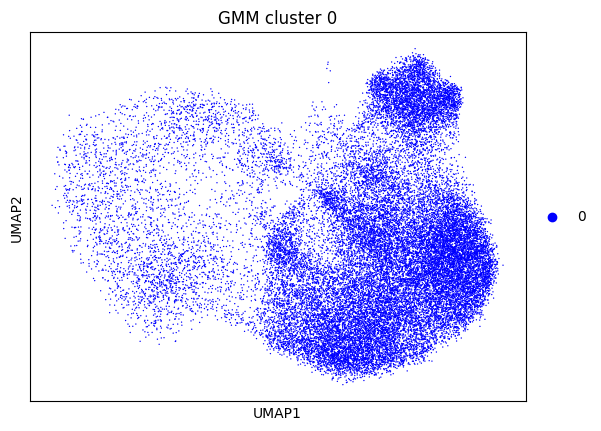

▶️ Cluster 1 - n_cells: 23880


/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/scanpy/plotting/_utils.py:491: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


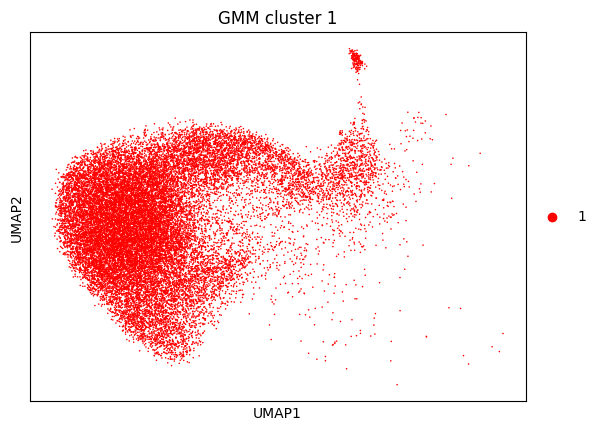

▶️ Cell type: Malignant - n_cells: 25000


/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/scanpy/plotting/_utils.py:491: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


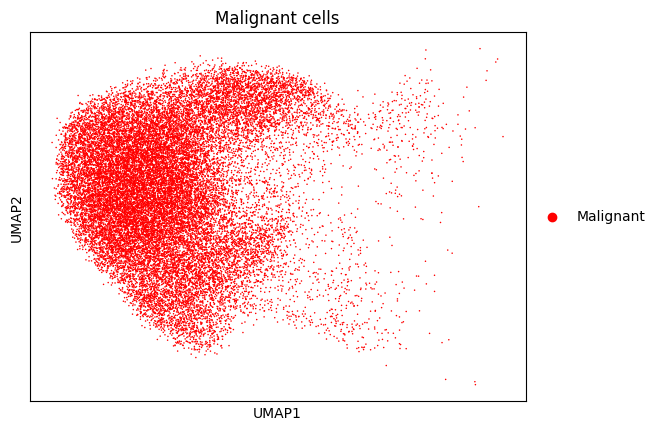

▶️ Cell type: Normal - n_cells: 25000


/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/scanpy/plotting/_utils.py:491: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


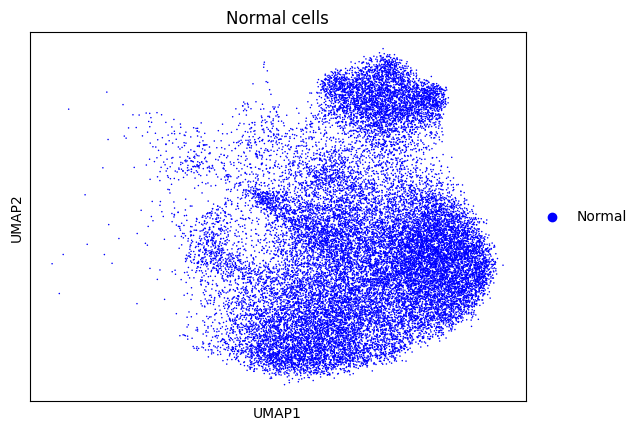

▶️ Cell type: Unknown - n_cells: 4882


/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/scanpy/plotting/_utils.py:491: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


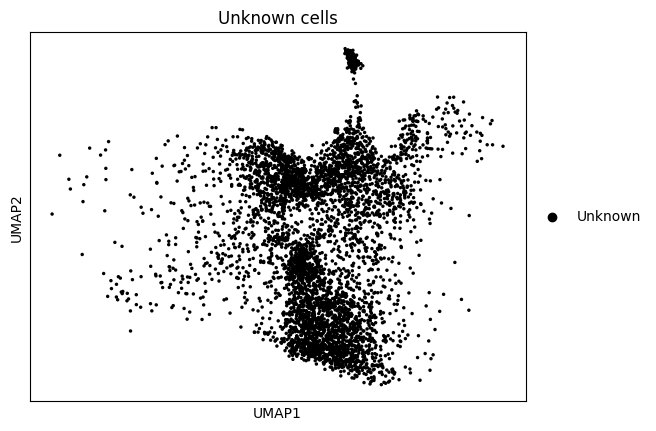

In [69]:
# PLOT SEPARATI PER OGNI CLUSTER di GMM 

for i, color in zip(['0', '1'], ['blue', 'red']):
    subset = adata_down[adata_down.obs['GMM_cluster'].astype(str) == i]
    print(f"▶️ Cluster {i} - n_cells: {subset.n_obs}")
    if subset.n_obs > 0:
        sc.pl.umap(subset, color='GMM_cluster', title=f'GMM cluster {i}',
                   palette=[color], show=True)

# PLOT SEPARATI PER OGNI CLUSTER di cell_type_prediction

for ct, color in zip(['Malignant', 'Normal', 'Unknown'], ['red', 'blue', 'black']):
    subset = adata_down[adata_down.obs['cell_type_prediction'].astype(str) == ct]
    print(f"▶️ Cell type: {ct} - n_cells: {subset.n_obs}")
    if subset.n_obs > 0:
        sc.pl.umap(subset,
                   color='cell_type_prediction',
                   title=f'{ct} cells',
                   palette=[color],
                   show=True)

/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/scanpy/plotting/_utils.py:491: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list
/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/scanpy/plotting/_utils.py:491: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list
/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/scanpy/plotting/_utils.py:491: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


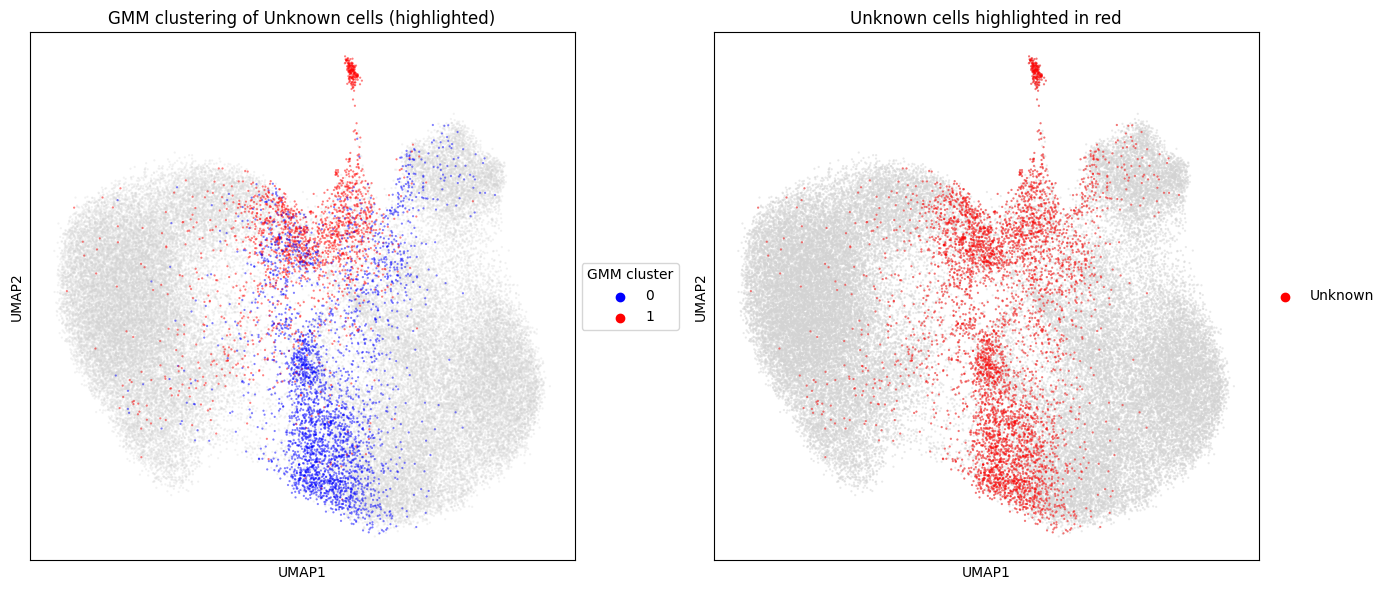

In [70]:
plot_gmm_vs_unknown_highlight(
    adata=adata_down,
    feature_key='cell_type_prediction',
    cluster_key='GMM_cluster',
    title_left='GMM clustering of Unknown cells (highlighted)',
    title_right='Unknown cells highlighted in red',
    save_path='figures/umap_gmm_unknown_highlighted.png'  # salva anche la figura)

In [78]:
# 12. Matrice di contingenza tra GMM e Cell Type
contingency_table = pd.crosstab(adata_down.obs['GMM_cluster'], adata_down.obs['cell_type_prediction'])
from IPython.display import display

display(contingency_table)


cell_type_prediction  Malignant  Normal  Unknown
GMM_cluster                                     
0                          3327   24595     3080
1                         21673     405     1802